### Code for Optimizing FATES Allometric Functions

#### Author: Katie Murenbeeld
#### Date: 19 July 2021

### 1. Load Libraries


In [1]:
# Load appropriate libraries
import xarray as xr
import random
import numpy as np
import pandas as pd
import scipy as sp
import math as m
from scipy import optimize
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

### 2. Define allometric functions that FATES currently uses

In [2]:
def d2h_chave2014(d,p1,p2,p3):
    h = np.exp( p1 + p2*np.log(d) + p3*np.log(d)**2.0)
    return(h)

def d2h_poorter2006(d,p1,p2,p3):
    h = p1*(1.0 - np.exp(p2*d**p3))
    return(h)

def d2h_2pwr(d,p1,p2):
    h = p1*d**p2
    return(h)

def d2h_obrien(d,p1,p2):
    h = 10.0**(np.log10(d)*p1+p2)
    return(h)

def d2h_martcano(d,p1,p2,p3):
    h = (p1*d**p2)/(p3+d**p2)
    return(h)

def carea_2pwr(d, p1, p2):
    c = p1 * d ** p2
    return(c)

def d2blmax_salda(d,p1,p2,p3,rho):
    blmax = p1 * d**p2 * rho**p3
    return(blmax)

def d2blmax_2pwr(d,p1,p2):
    c2b = 2.0
    blmax    = (p1*d**p2) / c2b
    return(blmax)

def d2bagw_choj(dbh,p1,p2):
    ln_agb = p1+(p2*np.log(dbh))
    agb_choj = np.exp(ln_agb)
    return agb_choj

def d2bagw_sal(dbh,p1,p2,p3,p4):
    agb_sal = allom_frac * p1 * (h_sal_mod**p2) * (dbh**p3) * (rho**p4)
    return agb_sal

def d2bagw_pow(dbh,p1,p2):
    agb_pow = (p1*np.power(dbh,p2))/c2b
    return agb_pow

### 3) Load data

Here we are using data from:

1. Falster et al., 2011 A Biomass and Allometry Database (BAAD)
2. USDA Forest Inventory Analysis (FIA) for Idaho
3. USDA Height and diameter at breast height (dbh) data from the Boise Basin Experimental Forest (BBEF)

We subset the data for Idaho or the western US. We are looking at common conifer species of Idaho. These include:

* Ponderosa pine (*Pinus ponderosa*)
* Lodgepole pine (*Pinus contorta*)
* Western white pine (*Pinus monticola*)
* Douglas-fir (*Pseudotsuga menziesii*)
* Western hemlock (*Tsuga heterophylla*)
* Western red cedar (*Thuja plicata*)
* Western larch (*Larix occidentalis*)
* Grand fir (*Abies grandis*)
* Subalpine fir (*Abies lasiocarpa*)
* Engelmann spruce (*Picea engelmanni*)

For now, I am looking at the pines, which will comprise for PFT1, and Douglas-fir and W. hemlock which will comprise PFT4.

In [3]:
# Set the directories
baad_dir = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/baad_downloads/baad_data/'
baad_dir_out = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/baad_downloads/baad_data_out/'
bbef_dir = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/BBEF/DATA/'
bbef_dir_out = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/BBEF/DATA/'
fia_dir = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/Benchmarking_Sensitivity/FIA/FIA_ID/'
fia_dir_out = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/Benchmarking_Sensitivity/FIA/FIA_ID_OUT/'

In [4]:
# Read in the BAAD data
baad_df = pd.read_csv(baad_dir + 'baad_data_2.csv').reset_index() 
baad_df = baad_df[['species', 'location', 'h.t', 'd.bh', 'a.lf', 'a.cp', 'm.lf', 'ma.ilf', 'n.lf', 'm.so']].copy()

# Read in the BBEF data
bbef_df = pd.read_csv(bbef_dir + 'BBEF-all-trees-height_DBH_calcs.csv')

# Read in the FIA Idaho census data
fia_df = pd.read_csv(fia_dir + 'ID_TREE.csv')
fia_df = fia_df[['PLT_CN', 'COUNTYCD', 'INVYR', 'CONDID', 'AZIMUTH', 'SPCD', 'SPGRPCD', 
                       'DIA', 'HT', 'CR', 'CDENCD', 'BHAGE', 'FGROWCFGS', 'TPA_UNADJ',  
                       'DRYBIO_BG', 'CARBON_AG', 'CARBON_BG', 'DRYBIO_AG']].copy()

/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# For the FIA data rename the species of interest

conditions = [
        (fia_df['SPCD'] == 202), # Douglas fir
        (fia_df['SPCD'] == 242), # Western red cedar
        (fia_df['SPCD'] == 19),  # Subalpine fir
        (fia_df['SPCD'] == 119), # Western white pine
        (fia_df['SPCD'] == 17),  # Grand fir
        (fia_df['SPCD'] == 73),  # Western larch
        (fia_df['SPCD'] == 122), # Ponderosa pine
        (fia_df['SPCD'] == 263), # Western hemlock
        (fia_df['SPCD'] == 108), # Lodgepole pine
        (fia_df['SPCD'] == 93),  # Engleman spruce
    ]
choices = ['doug-fir', 'w_redcedar', 'subap_fir', 'ww_pine', 'grand_fir', 'w_larch', 'pondo_pine', 'w_hem', 'lodge_pine', 'engle_spruce']
    
fia_df['SPECIES'] = np.select(conditions, choices, default='none')

fia_df.head(2)



,PLT_CN,COUNTYCD,INVYR,CONDID,AZIMUTH,SPCD,SPGRPCD,DIA,HT,CR,CDENCD,BHAGE,FGROWCFGS,TPA_UNADJ,DRYBIO_BG,CARBON_AG,CARBON_BG,DRYBIO_AG,SPECIES
0,3156095010690,9,1991,1,89.0,202,10,10.6,57.0,65.0,NaN,28.0,0.643645,13.054000,110.124965,240.460065,55.062483,NaN,doug-fir
1,3156095010690,9,1991,1,133.0,202,10,6.8,45.0,45.0,NaN,32.0,0.260028,31.720993,37.630405,80.531243,18.815203,NaN,doug-fir


In [6]:
# For each dataset sort out for the 10 conifer species of interest for the SCGSR work. Scratch that. 
# Just the species for PFT1 ( 3 pine species) and PFT 4 (W. Hemlock and Douglas Fir).

baad_2pfts = baad_df.loc[(baad_df['species'] == 'Pinus ponderosa') | (baad_df['species'] == 'Pinus monticola') | (baad_df['species'] == 'Pinus contorta') | (baad_df['species'] == 'Tsuga heterophylla') | (baad_df['species'] == 'Pseudotsuga menziesii')].copy()

bbef_2pfts = bbef_df.loc[(bbef_df['Species'] == 'Ponderosa pine') | (bbef_df['Species'] == 'Lodgepole pine') | (bbef_df['Species'] == 'Douglas fir') | (bbef_df['Species'] == 'Douglas fir') | (bbef_df['Species'] == 'Douglas fir')].copy()

fia_2pfts = fia_df.loc[(fia_df['SPECIES'] == 'pondo_pine') | (fia_df['SPECIES'] == 'lodge_pine') | (fia_df['SPECIES'] == 'ww_pine') | (fia_df['SPECIES'] == 'doug-fir') | (fia_df['SPECIES'] == 'w_hem')].copy()



In [7]:
bbef_2pfts

,BBEF Study-name,Year,Plot ID,Tree ID,Species,DBH (inches),Height (feet),DBH (cm),H (m),AGB,Unnamed: 10,Unnamed: 11,param 1,param 2
0,Amber Fuels,2013,451,1,Ponderosa pine,31.600000,127.0,80.264000,38.7096,7.961826,NaN,pines,-2.6177,2.4638
1,Amber Fuels,2013,451,2,Ponderosa pine,20.700001,102.0,52.578003,31.0896,5.063293,NaN,Doug fir,-2.4623,2.4852
2,Amber Fuels,2013,452,1,Ponderosa pine,19.000000,79.0,48.260000,24.0792,4.619666,NaN,firs,-3.1774,2.6426
3,Amber Fuels,2013,452,2,Ponderosa pine,16.900000,76.0,42.926000,23.1648,4.075513,NaN,NaN,NaN,NaN
4,Amber Fuels,2013,452,3,Ponderosa pine,44.900002,115.0,114.046005,35.0520,11.594535,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5518,Watershed,2005,99,993,Douglas fir,6.600000,51.0,16.764000,15.5448,1.786973,NaN,NaN,NaN,NaN
5519,Watershed,2005,99,994,Douglas fir,6.900000,52.0,17.526000,15.8496,1.874797,NaN,NaN,NaN,NaN
5520,Watershed,2005,99,9990,Ponderosa pine,23.900000,96.0,60.705999,29.2608,5.905157,NaN,NaN,NaN,NaN
5521,Watershed,2005,99,9991,Ponderosa pine,32.500000,113.0,82.550000,34.4424,8.204703,NaN,NaN,NaN,NaN


In [8]:
# Clean up and convert USDA FS data to metric 
baad_2pfts['DBH (cm)'] = baad_2pfts['d.bh']*100

bbef_2pfts['DBH (m)'] = bbef_2pfts['DBH (cm)']/100
bbef_2pfts = bbef_2pfts.drop(columns = ['Unnamed: 10', 'Unnamed: 11', 'param 1', 'param 2'])

fia_2pfts['HT (m)'] = fia_2pfts['HT'] * 0.3048
fia_2pfts['DBH (cm)'] = fia_2pfts['DIA'] * 2.54
fia_2pfts['DBH (m)'] = fia_2pfts['DIA'] * 0.0254

In [9]:
baad_2pfts.head(2)
#bbef_2pfts

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
3428,Pinus ponderosa,northern Rocky Mountains U.S.A.,0.70104,NaN,NaN,0.186793,0.084007,NaN,NaN,NaN,NaN
3433,Pinus monticola,northern Rocky Mountains U.S.A.,0.85344,NaN,NaN,0.385989,0.078019,NaN,NaN,NaN,NaN


In [10]:
# Review the max and min height by location (BAAD only)
print("max = ", baad_2pfts.groupby('location')['h.t'].max(), "\nmin = ", baad_2pfts.groupby('location')['h.t'].min())


max =  location
Coast Range  Oregon, USA                                                                     48.190000
Coast Range  Roseburg Oregon, USA                                                             6.380000
Coastal Range Corvallis  Oregon, USA                                                          2.197000
Elk Creek                                                                                    26.300000
Gavin Lake                                                                                    5.040000
Ostrander Road, Kelso, WA, USA                                                               15.080000
Pilchuck Bridge, WA, USA                                                                     20.400000
Priest River Experimental Forest                                                             44.989998
Pringle Butte and Lookout Mountain                                                           13.700000
Robertson Main                                           

In [11]:
# Review the mean height by location (BAAD only)
print("mean\n", baad_2pfts.groupby('location')['h.t'].mean())


mean
 location
Coast Range  Oregon, USA                                                                     43.669167
Coast Range  Roseburg Oregon, USA                                                             5.563333
Coastal Range Corvallis  Oregon, USA                                                          1.727650
Elk Creek                                                                                    23.059167
Gavin Lake                                                                                    1.804070
Ostrander Road, Kelso, WA, USA                                                               13.376667
Pilchuck Bridge, WA, USA                                                                     17.466250
Priest River Experimental Forest                                                             27.480488
Pringle Butte and Lookout Mountain                                                            9.044694
Robertson Main                                            

In [12]:
# Review basic stats on height
print("BAAD\n", baad_2pfts['h.t'].describe(), "\nBBEF", bbef_2pfts['H (m)'].describe(), "\nFIA", fia_2pfts['HT'].describe())

# There is no way there is a 269 m tall tree at BBEF


BAAD
 count    554.000000
mean       9.457290
std       11.004398
min        0.390000
25%        1.768750
50%        4.420040
75%       12.832500
max       48.190000
Name: h.t, dtype: float64 
BBEF count    5497.000000
mean       16.466325
std         9.849402
min         0.304800
25%         8.991600
50%        15.910560
75%        22.981920
max       269.443200
Name: H (m), dtype: float64 
FIA count    123117.000000
mean         55.950267
std          24.666293
min           1.000000
25%          39.000000
50%          54.000000
75%          71.000000
max         200.000000
Name: HT, dtype: float64


In [13]:
# Drop the index with the max height (269.4432m) from the bbef_2pfts

indx = bbef_2pfts[ (bbef_2pfts['H (m)'] == bbef_2pfts['H (m)'].max())].index
bbef_2pfts.drop(indx, inplace=True)

bbef_2pfts['H (m)'].describe()

count    5496.000000
mean       16.420296
std         9.240118
min         0.304800
25%         8.991600
50%        15.910560
75%        22.981920
max        48.158400
Name: H (m), dtype: float64

In [14]:
indx

Int64Index([998], dtype='int64')

In [15]:
# Review basic stats on dbh
print("BAAD\n", baad_2pfts['d.bh'].describe(), "\nBBEF", bbef_2pfts['DBH (m)'].describe(), "\nFIA", fia_2pfts['DBH (m)'].describe())



BAAD
 count    365.000000
mean       0.209651
std        0.193406
min        0.002540
25%        0.071120
50%        0.150121
75%        0.274320
max        0.863600
Name: d.bh, dtype: float64 
BBEF count    5496.000000
mean        0.270919
std         0.203308
min         0.002540
25%         0.132080
50%         0.223520
75%         0.355600
max         2.870200
Name: DBH (m), dtype: float64 
FIA count    123117.000000
mean          0.265688
std           0.167102
min           0.025400
25%           0.157480
50%           0.220980
75%           0.327660
max           1.747520
Name: DBH (m), dtype: float64


In [16]:
# Combine all of the DBH and H datasets into one dataframe
TOT_DBH = pd.concat([baad_2pfts['d.bh'], bbef_2pfts['DBH (m)'], fia_2pfts['DBH (m)']], axis=0, ignore_index=True)
TOT_H = pd.concat([baad_2pfts['h.t'], bbef_2pfts['H (m)'], fia_2pfts['HT (m)']], axis=0, ignore_index=True)

TOT = pd.concat([pd.DataFrame(TOT_DBH, columns=['DBH(m)']), pd.DataFrame(TOT_H, columns=['H(m)'])], axis=1)
TOT['DBH(cm)'] = TOT['DBH(m)'] * 100
TOT

,DBH(m),H(m),DBH(cm)
0,NaN,0.70104,NaN
1,NaN,0.85344,NaN
2,NaN,0.85344,NaN
3,NaN,0.85344,NaN
4,NaN,1.06680,NaN
...,...,...,...
135374,0.14224,6.09600,14.224
135375,0.38354,14.32560,38.354
135376,NaN,NaN,NaN
135377,0.15748,9.75360,15.748


In [17]:
# Find the mean height for specified ranges of DBH. 
# Here for a dbh of 10cm I took the measurements from 5-15cm to represent 10cm dbh. 
# Repeat the process up to 90cm.
# These values will be used to calculate parameters from the allometric equations (this acutally may not be necessary)

# Set dbh_mod to the ranges of dbh needed for calculation. In this case I want an array from 10-90 in steps of 10.
dbh_mod = np.arange(10, 100, 10) 

baad_mean_h = []

for i in dbh_mod:
    mask =  (baad_2pfts['d.bh']>= ((i/100) - 0.05)) & (baad_2pfts['d.bh']<((i/100) + 0.05))
    tmp_ = baad_2pfts.loc[mask].copy()
    stats = tmp_['h.t'].mean()
    baad_mean_h.append(stats)
    
bbef_mean_h = []

for i in dbh_mod:
    mask =  (bbef_2pfts['DBH (m)']>= ((i/100) - 0.05)) & (bbef_2pfts['DBH (m)']<((i/100) + 0.05))
    tmp_ = bbef_2pfts.loc[mask].copy()
    stats = tmp_['H (m)'].mean()
    bbef_mean_h.append(stats)

fia_mean_h = []

for i in dbh_mod:
    mask =  (fia_2pfts['DBH (m)']>= ((i/100) - 0.05)) & (fia_2pfts['DBH (m)']<((i/100) + 0.05))
    tmp_ = fia_2pfts.loc[mask].copy()
    stats = tmp_['HT (m)'].mean()
    fia_mean_h.append(stats)
    
tot_mean_h = []

for i in dbh_mod:
    mask =  (TOT['DBH(m)']>= ((i/100) - 0.05)) & (TOT['DBH(m)']<((i/100) + 0.05))
    tot_ = TOT.loc[mask].copy()
    stats = tot_['H(m)'].mean()
    tot_mean_h.append(stats)

### 3) Fit parameters for the allometric functions using curve_fit()


In [18]:
## Create a vector or dataframe with the height and dbh values for each of the three datasets and for the combined 
## (TOT) dataset

BBEF_DBH = bbef_2pfts['DBH (cm)'].values
BAAD_DBH = baad_2pfts['DBH (cm)'].values
FIA_DBH = fia_2pfts['DBH (cm)'].values
TOT_DBH = TOT['DBH(cm)'].values

BBEF_H = bbef_2pfts['H (m)'].values
BAAD_H = baad_2pfts['h.t'].values
FIA_H = fia_2pfts['HT (m)'].values
TOT_H = TOT['H(m)'].values

BAAD_Hobs = baad_mean_h
BBEF_Hobs = bbef_mean_h
FIA_Hobs = fia_mean_h
TOT_Hobs = tot_mean_h


In [19]:
# If you would like you can define an objective/cost function for the d2h function. In this case RMSE.
# Then I want to create an objective function. I will use RMSE

def d2h_error(dbh,Hobs,p1,p2):
    h = 10**((np.log10(dbh))*p1+p2)
    RMSE = np.sqrt(np.mean((h-Hobs)**2)) # best to use numpy
    return RMSE

In [20]:
RMSE = d2h_error(10,6.24,0.65,0.18)
print(RMSE)

0.520829753919819


### 3.1) For the d2h allometries fit the data to all of the functions. Then just the datasets to the O'Brien function.

We will also randomly sample and optimize the parameters to get a distribution of p1 and p2 for the O'Brien equation.

[0.55351031 0.46426406]
[33.83788175 -0.03459321  0.95645277]
[2.91250036 0.55350904]
[-0.58613253  1.53484833 -0.1416356 ]
[41.27875582  1.11514326 47.02661292]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


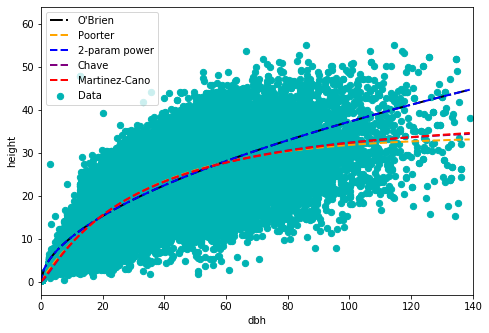

In [21]:
TOT_na = TOT.dropna(subset = ['DBH(cm)', 'H(m)']).copy()

pars_obrien, cov_obrien = curve_fit(f=d2h_obrien, xdata=TOT_na['DBH(cm)'].dropna(), ydata=TOT_na['H(m)'].dropna())
print(pars_obrien)
pars_poorter2006, cov_poorter2006 = curve_fit(f=d2h_poorter2006, xdata=TOT_na['DBH(cm)'].dropna(), ydata=TOT_na['H(m)'].dropna(), p0=[10,-0.01,1])
print(pars_poorter2006)
pars_2pwr, cov_2pwr = curve_fit(f=d2h_2pwr, xdata=TOT_na['DBH(cm)'].dropna(), ydata=TOT_na['H(m)'].dropna())
print(pars_2pwr)
pars_chave2014, cov_chave2014 = curve_fit(f=d2h_chave2014, xdata=TOT_na['DBH(cm)'].dropna(), ydata=TOT_na['H(m)'].dropna())
print(pars_chave2014)
pars_martcano, cov_martcano = curve_fit(f=d2h_martcano, xdata=TOT_na['DBH(cm)'].dropna(), ydata=TOT_na['H(m)'].dropna(), p0=[10,1,100])
print(pars_martcano)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('height')
ax.scatter(TOT['DBH(cm)'], TOT['H(m)'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *pars_obrien), linestyle='-.', linewidth=2, color='black', label="O'Brien")
ax.plot(np.arange(140), d2h_poorter2006(np.arange(140), *pars_poorter2006), linestyle='--', linewidth=2, color='orange', label="Poorter")
ax.plot(np.arange(140), d2h_2pwr(np.arange(140), *pars_2pwr), linestyle='--', linewidth=2, color='blue', label="2-param power")
ax.plot(np.arange(140), d2h_chave2014(np.arange(140), *pars_chave2014), linestyle='--', linewidth=2, color='purple', label="Chave")

ax.plot(np.arange(140), d2h_martcano(np.arange(140), *pars_martcano), linestyle='--', linewidth=2, color='red', label="Martinez-Cano")
ax.set_xlim(0,140)
ax.legend()

[0.84276166 0.0412515 ]
[0.63029409 0.34579944]
[0.54789134 0.47262309]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


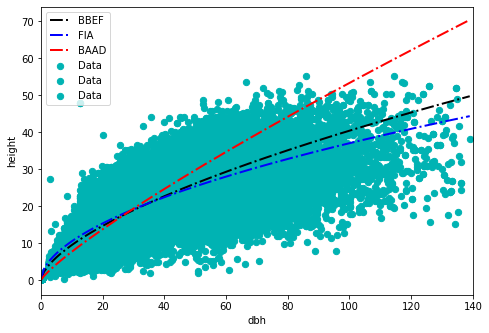

In [22]:
# Just using the O'Brien equation. Create optimal parameters for each of the three datasets.

baad_df2 = baad_2pfts.dropna(subset=['DBH (cm)'])
parsbaad_obrien, covbaad_obrien = curve_fit(f=d2h_obrien, xdata=baad_df2['DBH (cm)'], ydata=baad_df2['h.t'])
print(parsbaad_obrien)
parsbbef_obrien, covbbef_obrien = curve_fit(f=d2h_obrien, xdata=BBEF_DBH, ydata=BBEF_H)
print(parsbbef_obrien)
parsfia_obrien, covfia_obrien = curve_fit(f=d2h_obrien, xdata=fia_2pfts['DBH (cm)'].dropna(), ydata=fia_2pfts['HT (m)'].dropna())
print(parsfia_obrien)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('height')
ax.scatter(fia_2pfts['DBH (cm)'], fia_2pfts['HT (m)'], s=40, color='#00b3b3', label='Data')
ax.scatter(BBEF_DBH, BBEF_H, s=40, color='#00b3b3', label='Data')
ax.scatter(baad_2pfts['DBH (cm)'], baad_2pfts['h.t'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *parsbbef_obrien), linestyle='-.', linewidth=2, color='black', label="BBEF")
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *parsfia_obrien), linestyle='-.', linewidth=2, color='blue', label="FIA")
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *parsbaad_obrien), linestyle='-.', linewidth=2, color='red', label="BAAD")
ax.set_xlim(0,140)
ax.legend()



In [23]:
# From the total dataset, sample 1000 random samples and calculate the optimal parameters for O'Brien.
# Repeat the sampling and optimization 100 times.
# Create histograms for the two parameters.

smp_opt_d2h = []

def d2h_params(data):
    smp_mean_h = []
    for i in dbh_mod:
        smp = data.sample(1000).dropna()
            
    smp_opt, smp_cov = curve_fit(f=d2h_obrien, xdata=smp['DBH(cm)'], ydata=smp['H(m)'])
    smp_opt_d2h.append(smp_opt)
    return smp_opt

In [25]:
smp_opt_d2h = []

for x in range(1,101):
    d2h_params(TOT)
    D2H_PARAMS_DF = smp_opt_d2h

d2h_params_df = pd.DataFrame(D2H_PARAMS_DF, columns=['d2h_p1', 'd2h_p2'])

(array([ 2.,  3.,  9., 21., 20., 21., 11.,  7.,  4.,  2.]),
 array([0.50856429, 0.5187589 , 0.52895352, 0.53914813, 0.54934275,
        0.55953737, 0.56973198, 0.5799266 , 0.59012121, 0.60031583,
        0.61051045]),
 <a list of 10 Patch objects>)

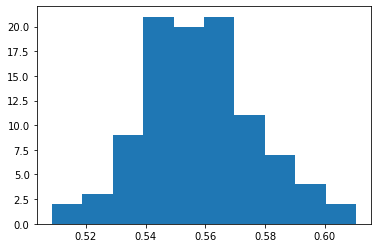

In [26]:
plt.hist(d2h_params_df['d2h_p1'])

(array([ 2.,  4.,  6., 10., 20., 21., 17., 12.,  6.,  2.]),
 array([0.3801738 , 0.39480164, 0.40942948, 0.42405732, 0.43868515,
        0.45331299, 0.46794083, 0.48256867, 0.49719651, 0.51182435,
        0.52645218]),
 <a list of 10 Patch objects>)

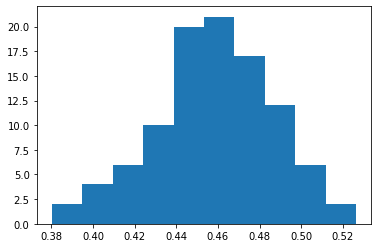

In [27]:
plt.hist(d2h_params_df['d2h_p2'])

In [28]:
# read out to a csv for use in the traits matrix
#d2h_params_df.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2f_params_20210720.csv', index=False)


### 3.2) We will optimize for the leaf biomass and crown area allometries using the BAAD data. 

#### First, projected crown area ($m^2$)

In [29]:
baad_2pfts.dropna(subset=['a.cp', 'DBH (cm)'])

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
3477,Pinus ponderosa,northern Rocky Mountains U.S.A.,1.402080,0.00762,NaN,0.263407,0.066997,NaN,NaN,NaN,0.762
3485,Pinus monticola,northern Rocky Mountains U.S.A.,1.584960,0.01016,NaN,0.531921,0.366010,NaN,NaN,NaN,1.016
3488,Pinus ponderosa,northern Rocky Mountains U.S.A.,1.615440,0.01016,NaN,0.656693,0.074980,NaN,NaN,NaN,1.016
3489,Pinus monticola,northern Rocky Mountains U.S.A.,1.615440,0.00762,NaN,0.656693,0.309990,NaN,NaN,NaN,0.762
3492,Pinus monticola,northern Rocky Mountains U.S.A.,1.645920,0.01270,NaN,0.893832,0.397989,NaN,NaN,NaN,1.270
...,...,...,...,...,...,...,...,...,...,...,...
11641,Pinus ponderosa,Priest River Experimental Forest,3.570000,0.04830,6.221753,0.833229,0.808352,NaN,NaN,NaN,4.830
11642,Pinus ponderosa,Priest River Experimental Forest,31.929997,0.70610,970.338487,36.513951,135.146738,NaN,NaN,NaN,70.610
11643,Pinus ponderosa,Priest River Experimental Forest,6.920000,0.11430,36.523412,4.856518,4.806629,NaN,NaN,NaN,11.430
11644,Pinus ponderosa,Priest River Experimental Forest,5.849999,0.11940,34.204490,3.397947,4.770014,NaN,NaN,NaN,11.940


[0.06375559 1.54726309]


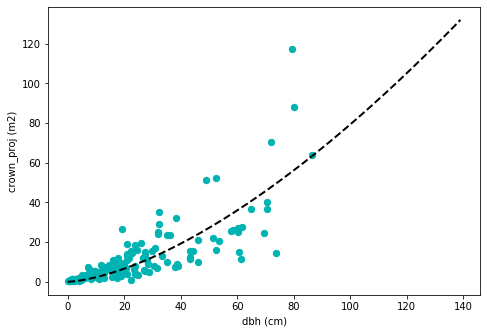

In [30]:
baad_acp = baad_2pfts.dropna(subset=['a.cp', 'DBH (cm)'])
crownarea_pars, crownarea_cov = curve_fit(f=carea_2pwr, xdata=baad_acp['DBH (cm)'], ydata=baad_acp['a.cp'])
print(crownarea_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acp['DBH (cm)'], baad_acp['a.cp'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *crownarea_pars), linestyle='--', linewidth=2, color='black')


(array([145.,  33.,  20.,  14.,   9.,   9.,  10.,   2.,   4.,   2.,   6.,
          4.,   1.,   1.,   0.,   3.,   0.,   1.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([6.36172512e-03, 2.35283169e+00, 4.69930165e+00, 7.04577161e+00,
        9.39224158e+00, 1.17387115e+01, 1.40851815e+01, 1.64316515e+01,
        1.87781214e+01, 2.11245914e+01, 2.34710614e+01, 2.58175313e+01,
        2.81640013e+01, 3.05104712e+01, 3.28569412e+01, 3.52034112e+01,
        3.75498811e+01, 3.98963511e+01, 4.22428211e+01, 4.45892910e+01,
        4.69357610e+01, 4.92822309e+01, 5.16287009e+01, 5.39751709e+01,
        5.63216408e+01, 5.86681108e+01, 6.10145808e+01, 6.33610507e+01,
        6.57075207e+01, 6.80539906e+01, 7.04004606e+01, 7.27469306e+01,
        7.50934005e+01, 7.74398705e+01, 7.97863405e+01, 8.21328104e+01,
        8.

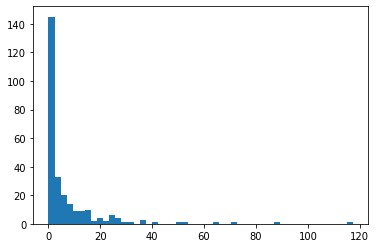

In [31]:
plt.hist(baad_2pfts['a.cp'].dropna(), bins=50)

In [32]:
baad_2pfts['a.cp'].describe()

count    270.000000
mean       6.931763
std       13.229655
min        0.006362
25%        0.321719
50%        2.069152
75%        7.705647
max      117.329860
Name: a.cp, dtype: float64

In [33]:
acp_log = np.log(baad_2pfts['a.cp'])
acp_log.describe()

count    270.000000
mean       0.453849
std        2.017091
min       -5.057456
25%       -1.134076
50%        0.726739
75%        2.041757
max        4.764989
Name: a.cp, dtype: float64

#### Then, leaf area ($m^2$)

In [34]:
baad_2pfts.dropna(subset=['a.lf', 'DBH (cm)'])

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
5992,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",32.60,0.627241,548.52,NaN,75.39,0.139586,NaN,NaN,62.724080
5993,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",33.60,0.544669,627.68,NaN,85.41,0.137430,NaN,NaN,54.466945
5994,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",34.10,0.661811,593.09,NaN,94.95,0.159400,NaN,NaN,66.181146
5995,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",31.70,0.677967,415.71,NaN,62.74,0.154386,NaN,NaN,67.796716
5996,Pinus ponderosa,"eastern side of the Oregon Cascade Range, USA ...",33.50,0.608698,575.45,NaN,83.92,0.143859,NaN,NaN,60.869755
...,...,...,...,...,...,...,...,...,...,...,...
15491,Pseudotsuga menziesii,Elk Creek,21.62,0.176000,40.22,NaN,6.80,NaN,NaN,NaN,17.600000
15492,Pseudotsuga menziesii,Robertson Main,17.85,0.171000,83.17,NaN,15.22,NaN,NaN,NaN,17.100000
15493,Pseudotsuga menziesii,Robertson Main,20.57,0.230000,76.22,NaN,13.50,NaN,NaN,NaN,23.000000
15494,Pseudotsuga menziesii,Robertson Main,14.43,0.099000,25.14,NaN,4.12,NaN,NaN,NaN,9.900000


[0.45220542 1.69916984]


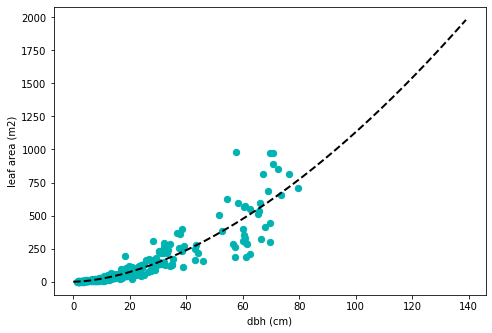

In [35]:
baad_alf = baad_2pfts.dropna(subset=['a.lf', 'DBH (cm)'])
leafarea_pars, leafarea_cov = curve_fit(f=carea_2pwr, xdata=baad_alf['DBH (cm)'], ydata=baad_alf['a.lf'])
print(leafarea_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf area (m2)')
ax.scatter(baad_alf['DBH (cm)'], baad_alf['a.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *leafarea_pars), linestyle='--', linewidth=2, color='black')
#ax.set_xlim(0,100)

(array([219.,  43.,  18.,  14.,  12.,   5.,   4.,   2.,   4.,   4.,   2.,
          0.,   3.,   1.,   3.]),
 array([2.65147650e-02, 6.56656984e+01, 1.31304882e+02, 1.96944066e+02,
        2.62583249e+02, 3.28222433e+02, 3.93861616e+02, 4.59500800e+02,
        5.25139984e+02, 5.90779167e+02, 6.56418351e+02, 7.22057535e+02,
        7.87696718e+02, 8.53335902e+02, 9.18975085e+02, 9.84614269e+02]),
 <a list of 15 Patch objects>)

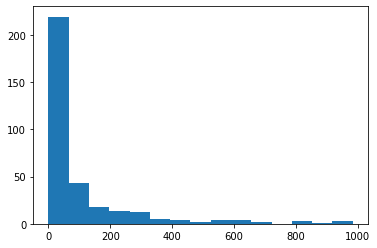

In [36]:
plt.hist(baad_2pfts['a.lf'].dropna(), bins=15)

In [37]:
baad_2pfts['a.lf'].describe()

count    334.000000
mean     103.222800
std      177.846543
min        0.026515
25%        4.655000
50%       31.100000
75%      108.190000
max      984.614269
Name: a.lf, dtype: float64

In [38]:
alf_log = np.log(baad_2pfts['a.lf'])
alf_log.describe()

count    334.000000
mean       3.060019
std        2.225335
min       -3.630054
25%        1.537926
50%        3.437173
75%        4.683887
max        6.892250
Name: a.lf, dtype: float64

#### Calculate the leaf crown exponent difference

In [39]:
leaf_crown_exponent_diff = crownarea_pars[1] - leafarea_pars[1]
print(leaf_crown_exponent_diff)

-0.15190675072595683


#### Next, the leaf mass (kg)

In [40]:
baad_2pfts.dropna(subset=['m.lf', 'DBH (cm)'])

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
3477,Pinus ponderosa,northern Rocky Mountains U.S.A.,1.40208,0.00762,NaN,0.263407,0.066997,NaN,NaN,NaN,0.762
3485,Pinus monticola,northern Rocky Mountains U.S.A.,1.58496,0.01016,NaN,0.531921,0.366010,NaN,NaN,NaN,1.016
3488,Pinus ponderosa,northern Rocky Mountains U.S.A.,1.61544,0.01016,NaN,0.656693,0.074980,NaN,NaN,NaN,1.016
3489,Pinus monticola,northern Rocky Mountains U.S.A.,1.61544,0.00762,NaN,0.656693,0.309990,NaN,NaN,NaN,0.762
3492,Pinus monticola,northern Rocky Mountains U.S.A.,1.64592,0.01270,NaN,0.893832,0.397989,NaN,NaN,NaN,1.270
...,...,...,...,...,...,...,...,...,...,...,...
15491,Pseudotsuga menziesii,Elk Creek,21.62000,0.17600,40.22,NaN,6.800000,NaN,NaN,NaN,17.600
15492,Pseudotsuga menziesii,Robertson Main,17.85000,0.17100,83.17,NaN,15.220000,NaN,NaN,NaN,17.100
15493,Pseudotsuga menziesii,Robertson Main,20.57000,0.23000,76.22,NaN,13.500000,NaN,NaN,NaN,23.000
15494,Pseudotsuga menziesii,Robertson Main,14.43000,0.09900,25.14,NaN,4.120000,NaN,NaN,NaN,9.900


[0.02262068 1.95947429]


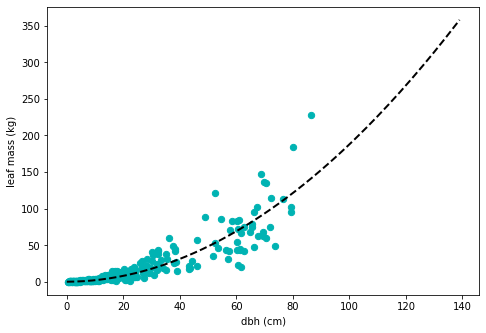

In [41]:
baad_mlf = baad_2pfts.dropna(subset=['m.lf', 'DBH (cm)'])
leafmass_pars, leafmass_cov = curve_fit(f=carea_2pwr, xdata=baad_mlf['DBH (cm)'], ydata=baad_mlf['m.lf'])
print(leafmass_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf mass (kg)')
ax.scatter(baad_mlf['DBH (cm)'], baad_mlf['m.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *leafmass_pars), linestyle='--', linewidth=2, color='black')

[0.045242   1.95947088]


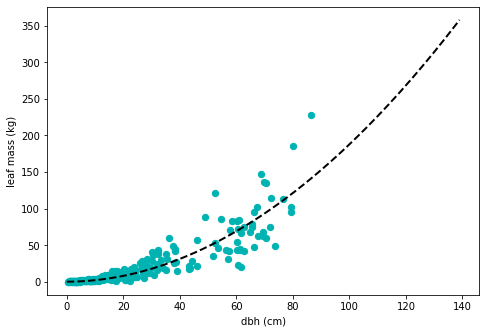

In [268]:
baad_mlf = baad_2pfts.dropna(subset=['m.lf', 'DBH (cm)'])
leafmass_pars2, leafmass_cov2 = curve_fit(f=d2blmax_2pwr, xdata=baad_mlf['DBH (cm)'], ydata=baad_mlf['m.lf'])
print(leafmass_pars2)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf mass (kg)')
ax.scatter(baad_mlf['DBH (cm)'], baad_mlf['m.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2blmax_2pwr(np.arange(140), *leafmass_pars2), linestyle='--', linewidth=2, color='black')

In [43]:
mlf_df = baad_mlf[['DBH (cm)','m.lf']].copy()
mlf_cov = mlf_df.cov()
mlf_cov

,DBH (cm),m.lf
DBH (cm),457.129230,611.940991
m.lf,611.940991,1107.662742


(array([0.04699126, 0.00677548, 0.00415272, 0.00196708, 0.00218564,
        0.00131138, 0.00087426, 0.00065569, 0.00043713, 0.00021856,
        0.        , 0.        , 0.00021856, 0.        , 0.00021856]),
 array([2.65800000e-03, 1.51527208e+01, 3.03027836e+01, 4.54528464e+01,
        6.06029092e+01, 7.57529720e+01, 9.09030348e+01, 1.06053098e+02,
        1.21203160e+02, 1.36353223e+02, 1.51503286e+02, 1.66653349e+02,
        1.81803412e+02, 1.96953474e+02, 2.12103537e+02, 2.27253600e+02]),
 <a list of 15 Patch objects>)

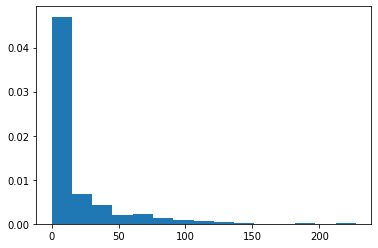

In [44]:
plt.hist(baad_2pfts['m.lf'].dropna(), bins=15, density=True)

In [45]:
baad_2pfts['m.lf'].describe()

count    302.000000
mean      17.691518
std       31.310988
min        0.002658
25%        0.475628
50%        4.110000
75%       18.165588
max      227.253600
Name: m.lf, dtype: float64

In [46]:
mlf_log = np.log(baad_2pfts['m.lf'])
mlf_log.describe()

count    302.000000
mean       1.054723
std        2.409439
min       -5.930181
25%       -0.743270
50%        1.413420
75%        2.899524
max        5.426067
Name: m.lf, dtype: float64

### From the distributions of the leaf and crown data generate samples to then calculate parameter values from

In [47]:
acp = np.random.lognormal(mean=0.453849, sigma=2.017091, size=100)
#plt.hist(acp, bins=100)
#plt.show()

In [48]:
alf = np.random.lognormal(mean=3.060019, sigma=2.225335, size=100)
#plt.hist(alf, bins=100)
#plt.show()

In [49]:
mlf = np.random.lognormal(mean=1.054723, sigma=2.409439, size=100)
#plt.hist(mlf, bins=100)
#plt.show()

In [50]:
np.log(1)

0.0

### 3.3 Diameter to above ground biomass (d2bagw)
Here I will test the Chojnacky (2014), the Saldarriaga et al. (1998) and the FATES 2 parameter power functions.

In [51]:
# From Delucia (2000), in montane ponderosa pine at dbh=50, agb=945. We will use this as a guide.
# We need to create an objective/cost function. Use RMSE for now.

def RMSE_d2bagw(agb_mod):
    RMSE_d2bagw = np.sqrt(np.mean((agb_mod-agb_obs)**2)) 
    return RMSE_d2bagw

# For d2abagw we will calculate the 

In [63]:
# Test the functions at dbh=50 to find RMSE for observed agb at dbh 50.
dbh_bagw = 50
agb_obs=945
allom_frac=0.6
c2b=2

# Chojnacky with default parameters for pines with density < 0.45
agb_choj = d2bagw_choj(dbh_bagw,-2.6177,2.4638)

# Saldarriaga with default parameters
#agb_sal = d2bagw_sal(dbh_bagw,0.284,0.57,1.94,1)

# 2-parameter with default parameters
agb_pow = d2bagw_pow(dbh_bagw,0.1,2.4)

#print("agb_choj =", agb_choj, "agb_sal=",agb_sal,"agb_pow=",agb_pow)
print("agb_choj =", agb_choj, "agb_pow=",agb_pow)

agb_choj = 1119.6173798341167 agb_pow= 597.720312368773


In [64]:
# Calculate the RMSE for each of the functions

RMSE_choj = RMSE_d2bagw(agb_choj)

#RMSE_sal = RMSE_d2bagw(agb_sal)

RMSE_pow = RMSE_d2bagw(agb_pow)

#print("choj RMSE=",RMSE_choj,", sal RMSE=",RMSE_sal,", power RMSE=",RMSE_pow)
print("choj RMSE=",RMSE_choj,", power RMSE=",RMSE_pow)

choj RMSE= 174.61737983411672 , power RMSE= 347.27968763122703


Well, they are all terrible.  How can I make them fit better?

In [69]:
# From the FIA data, calculate per acre above ground caron by multiplying the CARBON_AG * TPA_UNADJ

# Drop rows with na for CARBON_AG == 0.000
fia_agb = fia_2pfts.dropna(subset = ['DRYBIO_BG']).copy()

fia_agb['AGB'] = (fia_agb['CARBON_AG'] * fia_agb['TPA_UNADJ'])

# Convert lbC/ac to gC/m^2 to match FATES

fia_agb['AGB'] = (fia_agb['AGB'].values * 453.592 * 0.000247105)
fia_agb['AGB'].mean()


218.40367110124382

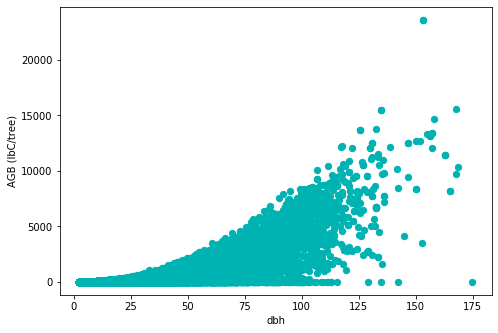

In [66]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('AGB (lbC/tree)')
ax.scatter(fia_2pfts['DBH (cm)'], fia_2pfts['CARBON_AG'], s=40, color='#00b3b3', label='Data')

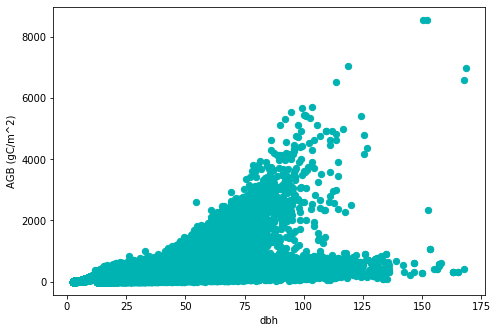

In [70]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('AGB (gC/m^2)')
#ax.scatter(fia_agb['DBH (cm)'], fia_agb['AGB'], s=40, color='#00b3b3', label='Data')
ax.scatter(fia_agb['DBH (cm)'], fia_agb['AGB'], s=40, color='#00b3b3', label='Data')


In [71]:
fia_pft1 = fia_agb.loc[(fia_2pfts['SPCD'] == 122) | (fia_agb['SPCD'] == 119) | (fia_agb['SPCD'] == 108)]
fia_pft4 = fia_agb.loc[(fia_2pfts['SPCD'] == 263) | (fia_agb['SPCD'] == 202)]

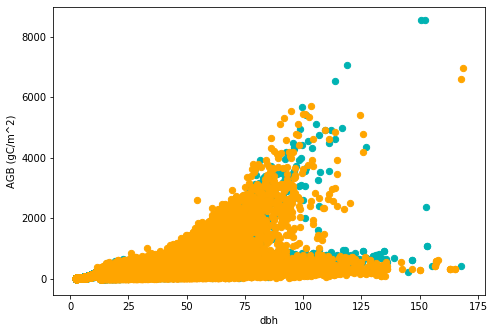

In [72]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('AGB (gC/m^2)')
ax.scatter(fia_pft1['DBH (cm)'], fia_pft1['AGB'], s=40, color='#00b3b3', label='Data')
ax.scatter(fia_pft4['DBH (cm)'], fia_pft4['AGB'], s=40, color='#ffa500', label='Data')

In [73]:
fia_agb = fia_agb.dropna(subset=['AGB', 'DBH (cm)'])
fia_agb

,PLT_CN,COUNTYCD,INVYR,CONDID,AZIMUTH,SPCD,SPGRPCD,DIA,HT,CR,...,TPA_UNADJ,DRYBIO_BG,CARBON_AG,CARBON_BG,DRYBIO_AG,SPECIES,HT (m),DBH (cm),DBH (m),AGB
0,3156095010690,9,1991,1,89.0,202,10,10.6,57.0,65.0,...,13.054000,110.124965,240.460065,55.062483,NaN,doug-fir,17.3736,26.924,0.26924,351.830502
1,3156095010690,9,1991,1,133.0,202,10,6.8,45.0,45.0,...,31.720993,37.630405,80.531243,18.815203,NaN,doug-fir,13.7160,17.272,0.17272,286.324226
3,3156095010690,9,1991,1,253.0,202,10,20.7,87.0,75.0,...,3.423000,568.025095,1261.636193,284.012548,NaN,doug-fir,26.5176,52.578,0.52578,484.047474
4,3156095010690,9,1991,1,285.0,202,10,17.3,78.0,75.0,...,4.901000,368.684807,816.035383,184.342404,NaN,doug-fir,23.7744,43.942,0.43942,448.270967
5,3156095010690,9,1991,1,47.0,202,10,1.4,12.0,25.0,...,60.000000,0.698412,1.129724,0.349206,NaN,doug-fir,3.6576,3.556,0.03556,7.597497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269937,354845607489998,81,2019,1,305.0,108,21,5.3,30.0,80.0,...,6.018046,11.534544,24.284499,5.767272,48.568998,lodge_pine,9.1440,13.462,0.13462,16.380667
269938,354845607489998,81,2019,1,356.0,108,21,5.6,20.0,75.0,...,6.018046,8.629705,18.241712,4.314853,36.483424,lodge_pine,6.0960,14.224,0.14224,12.304615
269939,354845607489998,81,2019,1,186.0,202,10,15.1,47.0,75.0,...,6.018046,163.560614,360.897561,81.780307,721.795121,doug-fir,14.3256,38.354,0.38354,243.436878
269942,354845607489998,81,2019,1,234.0,108,21,6.2,32.0,75.0,...,6.018046,19.063873,40.572438,9.531937,81.144876,lodge_pine,9.7536,15.748,0.15748,27.367399


[0.89355118 1.36203131]
[0.72792586 0.9359454  1.36203084 1.42626814]
[4.88700458 1.36206117]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


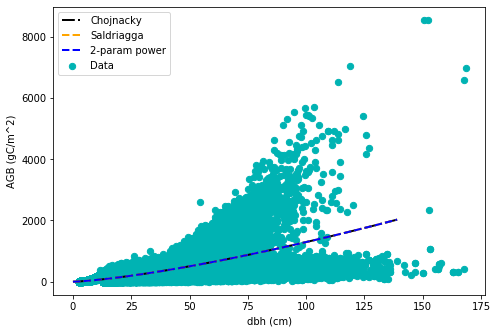

In [74]:
#fia_agb = fia_2pfts.dropna(subset=['AGB', 'DBH (cm)'])

# Define constants for the functions

# In d2bagw_sal
allom_frac = 0.6 
rho = 0.367 # Density of tree from USDA Survey of Tree Density, value for S. Idaho ponderosa pine
h_sal_mod = 29 # Observed height at dbh=50 from baad
# In d2bagw_pow
c2b = 2

pars_choj, cov_choj = curve_fit(f=d2bagw_choj, xdata=fia_agb['DBH (cm)'], ydata=fia_agb['AGB'])
print(pars_choj)
pars_sal, cov_sal = curve_fit(f=d2bagw_sal, xdata=fia_agb['DBH (cm)'], ydata=fia_agb['AGB'])
print(pars_sal)
pars_pow, cov_pow = curve_fit(f=d2bagw_pow, xdata=fia_agb['DBH (cm)'], ydata=fia_agb['AGB'])
print(pars_pow)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('AGB (gC/m^2)')
ax.scatter(fia_agb['DBH (cm)'], fia_agb['AGB'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2bagw_choj(np.arange(140), *pars_choj), linestyle='-.', linewidth=2, color='black', label="Chojnacky")
ax.plot(np.arange(140), d2bagw_sal(np.arange(140), *pars_sal), linestyle='--', linewidth=2, color='orange', label="Saldriagga")
ax.plot(np.arange(140), d2bagw_pow(np.arange(140), *pars_pow), linestyle='--', linewidth=2, color='blue', label="2-param power")

ax.legend()



In [75]:
## Something happened to the AGB with the conversion from lbC/tree to gC/m^2. Scewing the parameters. 
## Maybe mask for dbh>75 & agb <1000?
## I think just don't worry about the d2agb parameters.

[-1.53024522  2.15347754]
[0.09186371 0.84767401 2.15347752 1.48279119]
[0.43296559 2.1534773 ]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


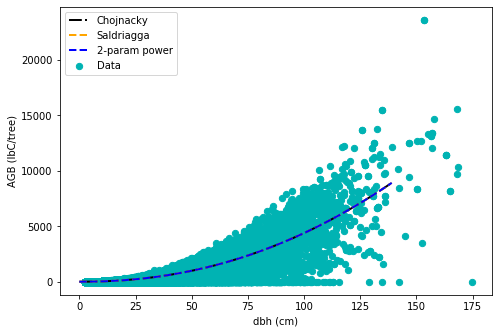

In [76]:
fia_cag = fia_2pfts.dropna(subset=['CARBON_AG', 'DBH (cm)'])

# Define constants for the functions

# In d2bagw_sal
allom_frac = 0.6 
rho = 0.367 # Density of tree from USDA Survey of Tree Density, value for S. Idaho ponderosa pine
h_sal_mod = 29 # Observed height at dbh=50 from baad
# In d2bagw_pow
c2b = 2

pars_choj, cov_choj = curve_fit(f=d2bagw_choj, xdata=fia_cag['DBH (cm)'], ydata=fia_cag['CARBON_AG'])
print(pars_choj)
pars_sal, cov_sal = curve_fit(f=d2bagw_sal, xdata=fia_cag['DBH (cm)'], ydata=fia_cag['CARBON_AG'])
print(pars_sal)
pars_pow, cov_pow = curve_fit(f=d2bagw_pow, xdata=fia_cag['DBH (cm)'], ydata=fia_cag['CARBON_AG'])
print(pars_pow)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('AGB (lbC/tree)')
ax.scatter(fia_cag['DBH (cm)'], fia_cag['CARBON_AG'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2bagw_choj(np.arange(140), *pars_choj), linestyle='-.', linewidth=2, color='black', label="Chojnacky")
ax.plot(np.arange(140), d2bagw_sal(np.arange(140), *pars_sal), linestyle='--', linewidth=2, color='orange', label="Saldriagga")
ax.plot(np.arange(140), d2bagw_pow(np.arange(140), *pars_pow), linestyle='--', linewidth=2, color='blue', label="2-param power")

ax.legend()



### For the d2ca, d2blmax, and d2agb chose a mean and variance and ramdonly sample 100 times. These will be brought over to the SCGSR Trait Matrix

In [264]:
# Dbh to project crown area, 2pwr
d2ca_p1 = crownarea_pars[0]
d2ca_p2 = crownarea_pars[1]
# Dbh to leaf area, 2pwr
d2la_p1 = leafarea_pars[0]
d2la_p2 = leafarea_pars[1]

# d2lf_ediff = crown area p2 - leaf area p2
crown_exp_diff = crownarea_pars[1] - leafarea_pars[1]

# d2leaf mass, carea 2pwr
d2blmax_ca_p1 = leafmass_pars[0]
d2blmax_ca_p2 = leafmass_pars[1]

# Dbh to leaf biomass d2blmax, 2pwr
d2blmax_p1 = leafmass_pars2[0]
d2blmax_p2 = leafmass_pars2[1] # crown_to_dbh_exp(crownare_exp)


In [267]:
print(d2blmax_p1, d2blmax_p2)

0.04524200489706767 1.9594708797115525


In [229]:
# could create a range of p1 and p2, then a for loop to recalculate crown area or leaf 
# random
random.seed(10)

d2ca_p1_rand = np.random.normal(loc=d2ca_p1, scale=(d2ca_p1/10), size=100)
d2ca_p2_rand = np.random.normal(loc=d2ca_p2, scale=(d2ca_p2/10), size=100)


In [95]:
d2ca_params = pd.DataFrame({'d2ca_p1': d2ca_p1_rand, 'd2ca_p2': d2ca_p2_rand}, columns = ['d2ca_p1', 'd2ca_p2'])
d2ca_params.head()

,d2ca_p1,d2ca_p2
0,0.061404,1.551010
1,0.055723,1.928905
2,0.073851,1.661455
3,0.058962,1.324716
4,0.059590,1.511618


In [246]:
# random
random.seed(10)

d2la_p1_rand = np.random.normal(loc=d2la_p1, scale=(d2la_p1/10), size=100)
d2la_p2_rand = np.random.normal(loc=d2la_p2, scale=(d2la_p2/10), size=100)

In [247]:
d2la_params = pd.DataFrame({'d2la_p1': d2la_p1_rand, 'd2la_p2': d2la_p2_rand}, columns = ['d2la_p1', 'd2la_p2'])
d2la_params.head()

,d2la_p1,d2la_p2
0,0.424301,1.559801
1,0.485938,1.990083
2,0.345137,1.589702
3,0.486237,1.641415
4,0.448857,1.439759


In [227]:
# random
random.seed(10)

d2blmax_ca_p1_rand = np.random.normal(loc=d2blmax_ca_p1, scale=(d2blmax_ca_p1/10), size=100)
d2blmax_ca_p2_rand = np.random.normal(loc=d2blmax_ca_p2, scale=(d2blmax_ca_p2/10), size=100)

In [100]:
d2blmax_ca_params = pd.DataFrame({'d2blmax_ca_p1': d2blmax_ca_p1_rand, 'd2blmax_ca_p2': d2blmax_ca_p2_rand}, 
                                 columns = ['d2blmax_ca_p1', 'd2blmax_ca_p2'])
d2blmax_ca_params.head()

,d2blmax_ca_p1,d2blmax_ca_p2
0,0.027955,1.774501
1,0.022717,1.901886
2,0.021844,2.044070
3,0.025576,1.871947
4,0.026493,1.693301


In [215]:
# random
random.seed(10)

d2blmax_p1_rand = np.random.normal(loc=d2blmax_p1, scale=(d2blmax_p1/10), size=100)
d2blmax_p2_rand = np.random.normal(loc=d2blmax_p2, scale=(d2blmax_p2/10), size=100)

In [216]:
d2blmax_params = pd.DataFrame({'d2blmax_p1': d2blmax_p1_rand, 'd2blmax_p2': d2blmax_p2_rand}, 
                                 columns = ['d2blmax_p1', 'd2blmax_p2'])
d2blmax_params.head()

,d2blmax_p1,d2blmax_p2
0,0.043254,2.052089
1,0.050199,2.222637
2,0.053798,1.855323
3,0.047724,1.854535
4,0.048998,2.134884


### Calculate crown area from the random parameters

In [218]:
# Calc crown area from random params

ca_rand_p = []

for i in range(100):

    test_ca = carea_2pwr(np.arange(0,90,5), d2ca_p1_rand[i], d2ca_p2_rand[i])
    ca_rand_p.append(test_ca)

ca_opt = carea_2pwr(np.arange(0,90,5), d2ca_p1, d2ca_p2)

In [219]:
print(d2ca_p1_rand[1], d2ca_p2_rand[1], ca_rand_p[1])

0.05572261506686569 1.9289050451869134 [  0.           1.2424481    4.73082121  10.34188854  18.01336347
  27.70288667  39.37840581  53.01419004  68.58878183  86.08380366
 105.48320154 126.77273559 149.93962063 174.97226341 201.86006462
 230.59326612 261.16283061 293.56034525]


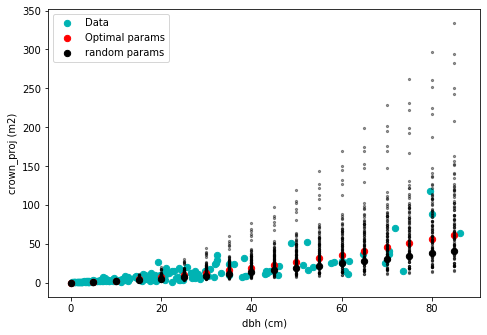

In [221]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acp['DBH (cm)'], baad_acp['a.cp'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), ca_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), ca_rand_p[7], s=40, color='black', label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), ca_rand_p[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 1.,  3.,  7.,  7., 19., 27., 18.,  8.,  7.,  3.]),
 array([0.04336044, 0.0468706 , 0.05038075, 0.05389091, 0.05740106,
        0.06091122, 0.06442138, 0.06793153, 0.07144169, 0.07495185,
        0.078462  ]),
 <a list of 10 Patch objects>)

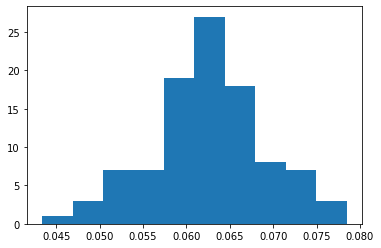

In [222]:
plt.hist(d2ca_p1_rand)

(array([ 2.,  4., 11., 18., 19., 19., 14.,  8.,  2.,  3.]),
 array([1.21331337, 1.28651227, 1.35971117, 1.43291006, 1.50610896,
        1.57930785, 1.65250675, 1.72570565, 1.79890454, 1.87210344,
        1.94530233]),
 <a list of 10 Patch objects>)

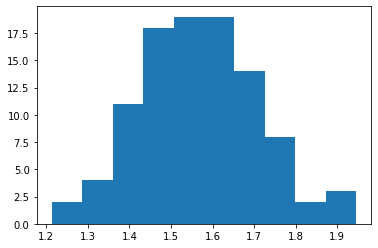

In [223]:
plt.hist(d2ca_p2_rand)

In [224]:
# d2ca_p2 > 1.77 caused problems
d2ca_params.index[d2ca_params['d2ca_p2'] >= 1.77].to_list()

[1, 14, 29, 68, 83, 85]

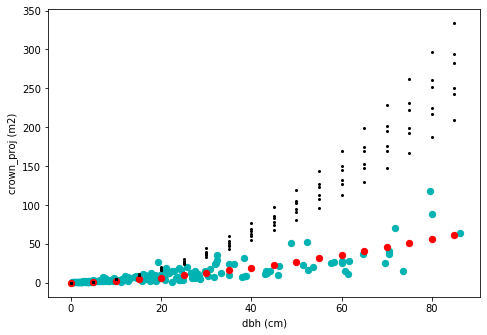

In [225]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acp['DBH (cm)'], baad_acp['a.cp'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), ca_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), ca_rand_p[1], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[8], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[14], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[26], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[29], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[54], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[60], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[68], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[72], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[83], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[85], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[95], s=4, color='black', label='random params')

In [279]:
# drop the problem values from the dataframe and save to a csv

d2ca_params_clean = d2ca_params.drop([d2ca_params.index[1], d2ca_params.index[14],d2ca_params.index[29], 
                                      d2ca_params.index[68], d2ca_params.index[83], d2ca_params.index[85]])

In [280]:
len(d2ca_params_clean)

94

In [286]:
# read out to a csv for use in the traits matrix
d2ca_params_clean.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2ca_params_clean_20210722.csv', index=False)


### Calculate leaf area from the random parameters

In [248]:
la_rand_p = []

for i in range(100):

    test_la = carea_2pwr(np.arange(0,90,5), d2la_p1_rand[i], d2la_p2_rand[i])
    la_rand_p.append(test_la)

la_opt = carea_2pwr(np.arange(0,90,5), d2la_p1, d2la_p2)

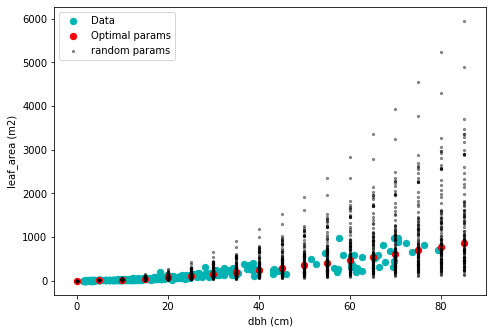

In [249]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_alf['DBH (cm)'], baad_alf['a.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), la_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), la_rand_p[7], s=5, color='black', alpha=0.4, label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), la_rand_p[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 2.,  4.,  8., 10., 20., 22., 19.,  8.,  4.,  3.]),
 array([0.31805885, 0.34401003, 0.36996121, 0.39591239, 0.42186357,
        0.44781476, 0.47376594, 0.49971712, 0.5256683 , 0.55161948,
        0.57757066]),
 <a list of 10 Patch objects>)

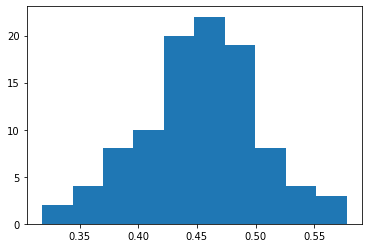

In [250]:
plt.hist(d2la_p1_rand)

(array([ 1.,  6.,  7., 11., 18., 20., 18.,  7., 10.,  2.]),
 array([1.24223365, 1.3313848 , 1.42053595, 1.5096871 , 1.59883825,
        1.6879894 , 1.77714055, 1.8662917 , 1.95544284, 2.04459399,
        2.13374514]),
 <a list of 10 Patch objects>)

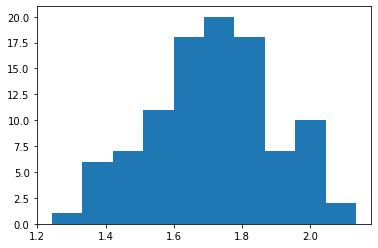

In [251]:
plt.hist(d2la_p2_rand)

In [256]:
# d2la_p2 > 1.95 caused problems
d2la_params.index[d2la_params['d2la_p2'] > 1.95].to_list()

[1, 8, 11, 33, 36, 49, 56, 57, 76, 81, 85, 94]

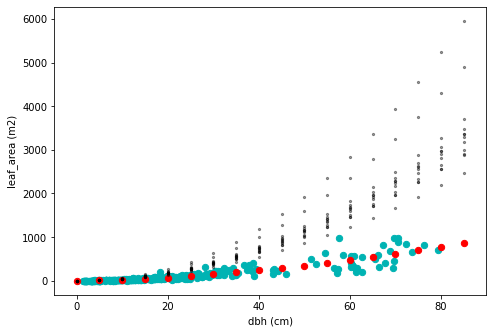

In [257]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_alf['DBH (cm)'], baad_alf['a.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), la_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), la_rand_p[1], s=5, color='black', alpha=0.4, label='random params')
ax.scatter(np.arange(0,90,5), la_rand_p[8], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[11], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[24], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[33], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[36], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[43], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[49], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[51], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[52], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[56], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[57], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[76], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[81], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[82], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[85], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[86], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[94], s=5, color='black', alpha=0.4)

In [283]:
d2la_params_clean = d2la_params.drop([d2la_params.index[1], d2la_params.index[8],d2la_params.index[11], 
                                      d2la_params.index[33], d2la_params.index[36], d2la_params.index[49],
                                           d2la_params.index[56], d2la_params.index[57], d2la_params.index[76],
                                        d2la_params.index[81], d2la_params.index[85], d2la_params.index[94]])


len(d2la_params_clean)

88

In [285]:
# read out to a csv for use in the traits matrix
d2la_params_clean.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2la_params_clean_20210722.csv', index=False)


### Calculate leaf mass from the random parameters

In [262]:
bl_rand_p = []

for i in range(100):

    test_bl = d2blmax_2pwr(np.arange(0,90,5), d2blmax_p1_rand[i], d2blmax_p2_rand[i])
    bl_rand_p.append(test_bl)

bl_opt = d2blmax_2pwr(np.arange(0,90,5), d2blmax_p1, d2blmax_p2)

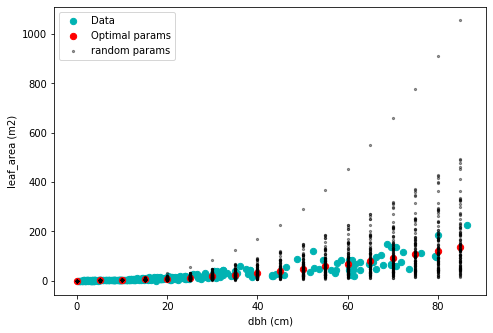

In [269]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_mlf['DBH (cm)'], baad_mlf['m.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), bl_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), bl_rand_p[7], s=5, color='black', alpha=0.4, label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), bl_rand_p[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 2.,  1.,  7., 18., 29., 20., 11.,  6.,  4.,  2.]),
 array([0.03265995, 0.03523452, 0.03780909, 0.04038366, 0.04295822,
        0.04553279, 0.04810736, 0.05068193, 0.05325649, 0.05583106,
        0.05840563]),
 <a list of 10 Patch objects>)

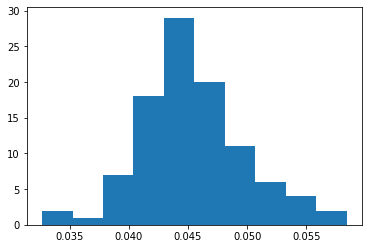

In [270]:
plt.hist(d2blmax_p1_rand)

(array([ 5.,  2., 14., 10., 23., 19., 15.,  7.,  4.,  1.]),
 array([1.47146776, 1.5668795 , 1.66229124, 1.75770297, 1.85311471,
        1.94852645, 2.04393818, 2.13934992, 2.23476166, 2.33017339,
        2.42558513]),
 <a list of 10 Patch objects>)

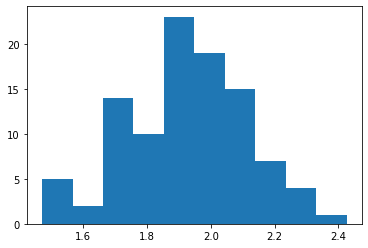

In [272]:
plt.hist(d2blmax_p2_rand)

In [275]:
# d2blmax_p2 > 2.2 caused problems
d2blmax_params.index[d2blmax_params['d2blmax_p2'] > 2.2].to_list()

[1, 13, 22, 43, 52, 55, 57, 79, 83]

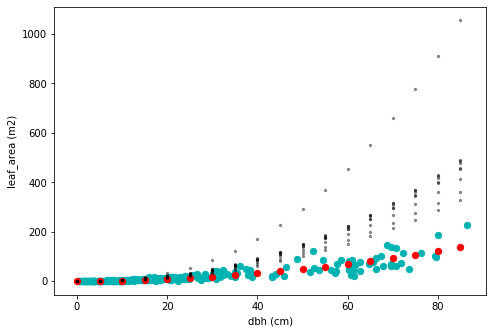

In [276]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_mass (kg)')
ax.scatter(baad_mlf['DBH (cm)'], baad_mlf['m.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), bl_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), bl_rand_p[1], s=5, color='black', alpha=0.4, label='random params')
ax.scatter(np.arange(0,90,5), bl_rand_p[13], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[22], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[43], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[52], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[55], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[57], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[79], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[83], s=5, color='black', alpha=0.4)

In [282]:
d2blmax_params_clean = d2blmax_params.drop([d2blmax_params.index[1], d2blmax_params.index[13],d2blmax_params.index[22], 
                                      d2blmax_params.index[43], d2blmax_params.index[52], d2blmax_params.index[55],
                                           d2blmax_params.index[57], d2blmax_params.index[79], d2blmax_params.index[83]])


len(d2blmax_params_clean)


91

In [284]:
# read out to a csv for use in the traits matrix
d2blmax_params_clean.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2blmax_params_clean_20210722.csv', index=False)
